## Импорт библиотек

In [ ]:
import json
import sys
import math
import numpy as np
from PIL import Image
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloader = drive.CreateFile({'id':'19ktOua0qXJi_7_JysVmFq_dAy7gBfhoU'})
downloader.GetContentFile('pic1.jpg')

downloader = drive.CreateFile({'id':'1a-6bfiyUEGyKa-9UE_4q4q7yLmnY5mMW'})
downloader.GetContentFile('pic2.jpg')

downloader = drive.CreateFile({'id':'1L3PN6N0sxtiezffuoYEH3Nl9CvghPh91'})
downloader.GetContentFile('pic3.jpg')

downloader = drive.CreateFile({'id':'1ylgZY8aRZ10JNXuj78LLbKizSzQ8g0DT'})
downloader.GetContentFile('test.json')

downloader = drive.CreateFile({'id':'1dj1lIZ7MS1IGCNvnMUNqwAXF76cLSL6-'})
downloader.GetContentFile('test2.json')

downloader = drive.CreateFile({'id':'1OOIyhesYnAfxHdDiCFGcPL_xdrAY7Wb6'})
downloader.GetContentFile('testMax1.json')

downloader = drive.CreateFile({'id':'16HvcbM5NWMvxCurOLrqjAHbt7K7HFKRm'})
downloader.GetContentFile('testMax2.json')

downloader = drive.CreateFile({'id':'1ibe1StbjiV7DOmH8woOgRgDZv5ie8AvQ'})
downloader.GetContentFile('testMax3.json')

downloader = drive.CreateFile({'id':'1vXjyyOpvB9N-zKfbr46LRNqWfcrGMiHQ'})
downloader.GetContentFile('testMax4.json')

downloader = drive.CreateFile({'id':'18lzjFTEibzxRfoiQPwdYpFgqVL_bDHBr'})
downloader.GetContentFile('testMin1.json')

## Парсинг json-файла

In [ ]:
def parse_json(json_name):
  with open(json_name) as json_file:
    data = json.load(json_file)

    c = data['f']

    constraints = data['constraints']

    goal = data['goal']

    ineq = 0
# создаем дополнительные столбцы для балансирующих переменных
    for constraint in constraints:
      if constraint['type'] != 'eq':
        ineq += 1

    columns = len(c) + ineq

    A = [[0] for _ in range(len(c))]

    b = []
    iter_for_balance_coefs = ineq
    for i in range(len(constraints)):
      constraint = constraints[i]
      next_A_row = []

      if constraint['b'] < 0:
        next_A_row.append += -constraint['coefs']
        b.append(-constraint['b'])
        if constraint['type'] != 'eq':
          if constraint['type'] == 'gte':
            constraint['type'] = 'lte'
          else:
            constraint['type'] = 'gte'
      else:
        next_A_row += constraint['coefs']
        b.append(constraint['b'])

      next_A_row += [0] * ineq

      if constraint['type'] == 'lte':
        next_A_row[len(c) + iter_for_balance_coefs - 1] = 1
        iter_for_balance_coefs -= 1
      elif constraint['type'] == 'gte':
        next_A_row[len(c) + iter_for_balance_coefs - 1] = -1
        iter_for_balance_coefs -= 1

      A[i] = next_A_row
    c += [0] * ineq

  return c, A, b, goal

In [ ]:
c, A, b, goal = parse_json("test.json")

print(c)
print(A)
print(b)

[1, 2, 3, 0, 0]
[[1, 0, 0, 0, 0], [1, 1, 0, 0, -1], [1, 1, 1, 1, 0]]
[1, 2, 3]


## Симплекс-метод

*Def: **Симплекс-метод** — алгоритм решения оптимизационной задачи линейного программирования путём перебора вершин выпуклого многогранника в многомерном пространстве.*

Линейное программирование строится на **линейной функции** и **линейных ограничениях**.

Есть общая постановка задачи:

**Линейная функция**
$f(x) = c_1x_1 + c_2x_2 + ... + c_nx_n \rightarrow min (max) $

**Линейные ограничения**
\begin{equation*}
 \begin{cases}
   α_{11}x_1 + α_{12}x_2 + ... + α_{1n}x_n \gt\lt b_1,
   \\
   α_{21}x_1 + α_{22}x_2 + ... + α_{2n}x_n \gt\lt b_2,
   \\
   ...,
   \\
   α_{m1}x_1 + α_{m2}x_2 + ... + α_{mn}x_n \gt\lt b_m.
 \end{cases}
\end{equation*}

В канонической постановке ограничения предполагаются в виде равенств. Чтобы перейти от общей постановки к канонической нужно добавить свободный коэффициент (балансирующие переменные).

**NB!** *если у нас встречается переменная $x_j 𝜖 (-∞;0)$, представляем ее как $x_j=z_j-y_j$, где $z_j, y_j \geq 0$*

Переходим к симплекс-методу. Он строится на том, что при выпуклой области допустимых решений можно представить ее многоугольником в пространстве (для функции от двух переменных - в декартовом) и относительно градиента двигать прямую. При пересечении прямой с границами многоугольника можно найти масимум и минимум.

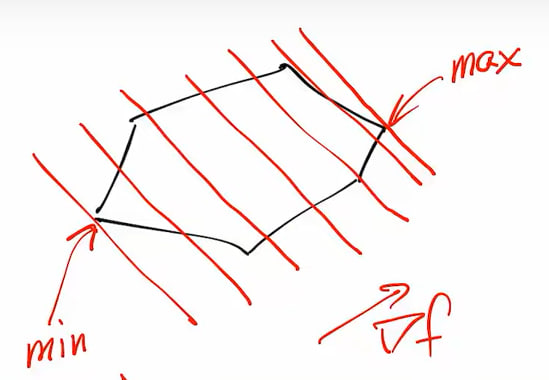

In [ ]:
img = Image.open('pic1.jpg')
img

Так же может быть ситуация с бесконечностью решений, если мы попадаем ровно на грань

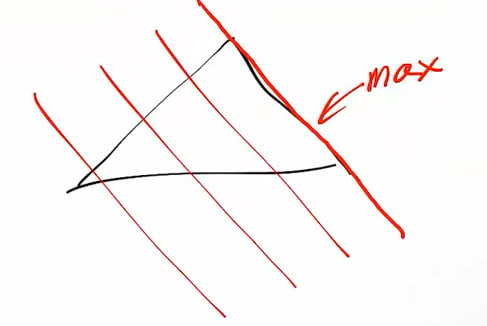

In [ ]:
img = Image.open('pic2.jpg')
img

И решений может не быть, если наш многоугольник не имеет верхней или нижней границы.

Итак, из двух теорем, приведенных на лекции следует, что **оптимум** будет находиться в этих угловых точках, а так же в области допустимых базисных решений.

Заметим, что в области допустимых решений при занулении n-m переменных (m - базис) мы получаем угловую точку.

**Симплекс метод** как раз и заключается в том, что мы последовательно перебираем все угловые точки.

Для эффективности мы строим алгоритм таким образом, чтобы наше решение улучшалось каждый раз, и наш опорный план был каждый раз ближе к оптимальному. Если у нас уже есть опорное решение, мы можем из него двигаться в другую угловую точку с некой логикой выбора, чтобы найти решение оптимальное.

При переходе от общей формы к канонической мы добавили свободные коэффициенты, тем самым получив из них базисные, а из изначальных переменных - не основные, принимающие произвольные значения. Через изначальные переменные выражаем все остальные. Затем, чтобы получить опорный план, проводим следующие шаги:

1. **Выбираем базисное решение.**
2. **Зануляем не основные переменные.**
3. **Переводим одну из изначальных переменных в основные,** убрав из основных взамен какую-то другую переменную, при этом следует следить за неотрицательностью. В итоге выбираем минимум из доступных значений.
4. **Выражаем новую основную переменную через неосновные.**
5. **Повторяем с остальными изначальными переменными.**

После этого мы получили опорный план и можем уже относительно него с новой функцией и новыми основными переменными продолжать работу.

В тот момент, когда мы доходим до функции вида $const - x_i - x_j...$ мы можем остановиться, так как все коэффициенты у нас положительные, и раз они входят в функцию с отрицательными коэффициентами, они могут только уменьшить значение функции относительно константы. Значит, эта наша константа и есть максимум! И это наш оптимальный опорный план.

В программировании лучше представлять этот метод **симплекс-таблицами**

Давайте переведем наши данные в симплекс-таблицу, она имеет следующий вид:

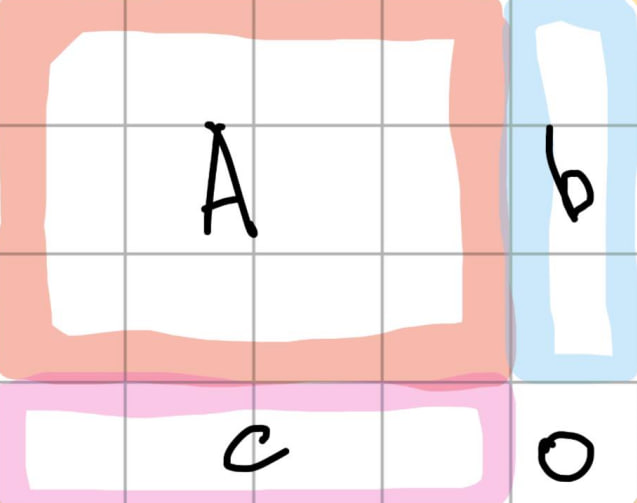

In [ ]:
img = Image.open('pic3.jpg')
img

In [ ]:
def create_simplex_table(c, A, b):
    xb = [eq + [x] for eq, x in zip(A, b)]
    z = c + [0]
    return xb + [z]

print(create_simplex_table(c, A, b))

[[1, 0, 0, 0, 0, 1], [1, 1, 0, 0, -1, 2], [1, 1, 1, 1, 0, 3], [1, 2, 3, 0, 0, 0]]


Отлично! Начнем по кусочкам собирать реализацию симплекс-метода

In [ ]:
import math

Первым делом создадим функцию, которая будет проверять остановку. Как мы показали выше, для максимизации функции - это все отрицательные коэффициенты функции, а для минимизации - наоборот

In [ ]:
def continue_condition(table, goal):
    z = table[-1]
    if goal == "max":
      return any(x > 0 for x in z[:-1])
    if goal == "min":
      return any(x < 0 for x in z[:-1])
    else:
      print("ERROR! please define goal only as \'max\' or \'min\'")
      return 0


Теперь создадим функцию, которая будет двигать наш пивот (опорный план)

In [ ]:
# вспомогательная функция чтобы из этой таблички наш опорный план собственно получить
def get_pivot_position(table, goal):
    z = table[-1]
    if goal == "max":
       column = next(i for i, x in enumerate(z[:-1]) if x > 0)
    else:
       column = next(i for i, x in enumerate(z[-2::-1]) if x < 0)

    restrictions = []
    for eq in table[:-1]:
        el = eq[column]
        if goal == "max":
          restrictions.append(math.inf if el <= 0 else eq[-1] / el)
        else:
          restrictions.append(math.inf if el >= 0 else eq[-1] / el)
    row = restrictions.index(min(restrictions))
    return row, column

In [ ]:
def pivot_step(table, pivot_position):
    new_table = [[] for eq in table]

    i, j = pivot_position
    pivot_value = table[i][j]
    new_table[i] = np.array(table[i]) / pivot_value

    for eq_i, eq in enumerate(table):
        if eq_i != i:
            multiplier = np.array(new_table[i]) * table[eq_i][j]
            new_table[eq_i] = np.array(table[eq_i]) - multiplier

    return new_table

И наконец нам нужно из нашей таблички достать решение

In [ ]:
def is_basic(column):
    return sum(column) == 1 and len([c for c in column if c == 0]) == len(column) - 1

def get_solution(table):
    columns = np.array(table).T
    solutions = []
    for column in columns[:-1]:
        solution = 0
        if is_basic(column):
            one_index = column.tolist().index(1)
            solution = columns[-1][one_index]
        solutions.append(solution)

    return solutions

Также стоит заметить, что первый опорный план стоит получать руками, чтобы была возможность минимизировать полностью положительные функции и максимизировать полностью отрицательные

In [ ]:
def start_pivot_position(table, goal):
    z = table[-1]
    column = 0

    restrictions = []
    for eq in table[:-1]:
        el = eq[column]
        if goal == "max":
          restrictions.append(math.inf if el <= 0 else eq[-1] / el)
        else:
          restrictions.append(math.inf if el >= 0 else eq[-1] / el)
    row = restrictions.index(min(restrictions))
    return row, column

Собираем все вместе:

In [ ]:
def simplex(c, A, b, goal):
    table = create_simplex_table(c, A, b)
    pivot_position = start_pivot_position(table, goal)
    table = pivot_step(table, pivot_position)

    while continue_condition(table, goal):
      pivot_position = get_pivot_position(table, goal)
      table = pivot_step(table, pivot_position)

    return get_solution(table)

## Тесты

In [ ]:
solution = simplex(c, A, b, goal)
print('solution: ', solution)

solution:  [1.0, 1.0, 1.0, 0, 0]


И давайте найдем сам максимум:

In [ ]:
answer = 0
for i in range(len(c)):
  answer += solution[i] * c[i]

answer

6.0

Еще немножко тестов!

In [ ]:
c, A, b, goal = parse_json("testMax1.json")
solution = simplex(c, A, b, goal)
print('solution: ', solution)

answer = 0
for i in range(len(c)):
  answer += solution[i] * c[i]

answer

solution:  [2.170731707317073, 1.2195121951219514, 1.5121951219512195, 0, 0, 0]


18.65853658536585

In [ ]:
c, A, b, goal = parse_json("testMax2.json")
solution = simplex(c, A, b, goal)
print('solution: ', solution)

answer = 0
for i in range(len(c)):
  answer += solution[i] * c[i]

answer

solution:  [9.75, 1.25, 0, 55.5, 0, 0]


222.0

In [ ]:
c, A, b, goal = parse_json("testMax3.json")
solution = simplex(c, A, b, goal)
print('solution: ', solution)

answer = 0
for i in range(len(c)):
  answer += solution[i] * c[i]

answer

solution:  [0, 0, 0, 3.75, 81.5, 96.25, 0, 67.0]


63.75

In [ ]:
c, A, b, goal = parse_json("testMax4.json")
solution = simplex(c, A, b, goal)
print('solution: ', solution)

answer = 0
for i in range(len(c)):
  answer += solution[i] * c[i]

answer

solution:  [25.555555555555557, 0, 0, 14.11111111111111, 0, 34.77777777777777, 431.0, 0]


546.5555555555555

In [ ]:
c, A, b, goal = parse_json("testMin1.json")
solution = simplex(c, A, b, goal)
print('solution: ', solution)

answer = 0
for i in range(len(c)):
  answer += solution[i] * c[i]

answer

solution:  [1.0, 0, 0, 2.0, 0]


3.0